In [1]:
!ls -l

total 128
-rw-rw-r-- 1 dpidave dpidave  2776 Jul  2 11:10 CR_09880W_A_DEF1.fasta
-rw-rw-r-- 1 dpidave dpidave 45288 Jul  2 11:10 DEF1 conversion.xlsx
-rw-rw-r-- 1 dpidave dpidave   252 Jul  2 11:10 DEF1-hp11vw (187).fasta
-rw-rw-r-- 1 dpidave dpidave   235 Jul  2 11:10 hp11vw_data.txt
-rw-rw-r-- 1 dpidave dpidave  9789 Jul  2 11:10 legend.png
-rw-rw-r-- 1 dpidave dpidave 15760 Jul  3 08:22 plotting.ipynb
-rw-rw-r-- 1 dpidave dpidave   291 Jul  2 11:10 sc5314 amplicon.fasta
-rw-rw-r-- 1 dpidave dpidave   246 Jul  2 11:10 sc5314_data.txt~
-rw-rw-r-- 1 dpidave dpidave   355 Jul  2 11:10 Sc5414_data.txt
-rw-rw-r-- 1 dpidave dpidave   366 Jul  2 11:10 Sc5414_data.txt~
-rw-rw-r-- 1 dpidave dpidave  1086 Jul  2 12:03 testfile_2.fasta
-rw-rw-r-- 1 dpidave dpidave 13229 Jul  3 08:20 test.png


This one I am just going to translate the sequences from Jans spreadsheet, just to get the plotting working. I'm sure I have to extract the sequences myself somehow in the future, but not sure at this stage as the seq cordinates seem to be for the reference (I gather I must have these alleles somewhere?)

In [2]:
!cat Sc5414_data.txt

39	GCGCAAGAAAGGGAAGAGTCAAATAAAAGACAACATACA
51	GAATCAAGTGCA
63	GAACCAAATGCA
75	GAACTGAGTACA
87	GAATCAACTACA
99	GAATCAAATGCT
111	GAATCAGGTGCT
123	GAACCAAATGCT
135	GAACCAAGTGCA
147	GAATCAACTACA
159	GAATCAAATGTT
171	GAATCAGGTGCT
183	GAACCAAATGCT
195	GAATCAGGTGCT
207	GAATCAGGTGCT
219	GAACCAACTGCT
231	GAATCAAATGCT
270	GAACTAAAGCAAAGAATTTGGGAAATTTTGAGTTACCGTT


In [3]:
!cat hp11vw_data.txt

39	GCGCAAGAAAGGGAAGAGTCAAATAAAAGACAACATACA
51	GAATCAAGTGCA
63	GAACCAAATGCA
75	GAACTGAGTACA
87	GAATCAACTACA
99	GAATCAAATGCT
111	GAATCAGGTGCT
123	GAATCAGGTGCT
135	GAACCAACTGCT
147	GAATCAAATGCT
186	GAACTAAAGCAAAGAATTTGGGAAATTTTGAGTTACCGT


In [49]:
#%matplotlib inline

In [77]:
# see the code replacement below
'''
from Bio import SeqIO
from Bio.Seq import Seq
# check yeast
from Bio.Alphabet import IUPAC

def collect_repeats(data):
    repeats = []
    for pos, rec in data:
        # just print a warning
        if len(rec) % 3:
            print('not multiple of 3?')
            print("%s-%s" % (pos, rec))
            print(str(rec.translate(table='Alternative Yeast Nuclear')))
        pep = str(rec.translate(table='Alternative Yeast Nuclear'))
        dna = str(rec)
        repeats.append((dna,pep))
    return repeats

def read_rep_data(fname):
    data = []
    with open(fname) as f:
        for line in f:
            bits = line.strip().split('\t')
            pos = bits[0]
            rec = Seq(bits[1], IUPAC.unambiguous_dna)
            data.append((pos, rec))
    return data
       
data1 = read_rep_data('Sc5414_data.txt')    
repeats1 = collect_repeats(data1)
data2 = read_rep_data('hp11vw_data.txt')
repeats2 = collect_repeats(data2)

strains = {'Sc5414':repeats1, 'hp11vw': repeats2}#, 'strain3':repeats3}
'''

'\nfrom Bio import SeqIO\nfrom Bio.Seq import Seq\n# check yeast\nfrom Bio.Alphabet import IUPAC\n\ndef collect_repeats(data):\n    repeats = []\n    for pos, rec in data:\n        # just print a warning\n        if len(rec) % 3:\n            print(\'not multiple of 3?\')\n            print("%s-%s" % (pos, rec))\n            print(str(rec.translate(table=\'Alternative Yeast Nuclear\')))\n        pep = str(rec.translate(table=\'Alternative Yeast Nuclear\'))\n        dna = str(rec)\n        repeats.append((dna,pep))\n    return repeats\n\ndef read_rep_data(fname):\n    data = []\n    with open(fname) as f:\n        for line in f:\n            bits = line.strip().split(\'\t\')\n            pos = bits[0]\n            rec = Seq(bits[1], IUPAC.unambiguous_dna)\n            data.append((pos, rec))\n    return data\n       \ndata1 = read_rep_data(\'Sc5414_data.txt\')    \nrepeats1 = collect_repeats(data1)\ndata2 = read_rep_data(\'hp11vw_data.txt\')\nrepeats2 = collect_repeats(data2)\n\nstrains

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# this was to double up ends to make double wide, doesn't work
#for strain in strains:
#    start = strains[strain][0]
#    end = strains[strain][-1]
#    strains[strain].insert(0, start)
#    strains[strain].insert(-1, end)

# colect all repeats and find unique ones to assign a color
uq_repeats = list(set([repeat[1] for repeat in strains for repeat in strains[repeat]]))

#np.random.seed(sum(map(ord, "palettes")))

col_dict = {}
col_opts = sns.xkcd_rgb.keys()
n = 0
for rep in uq_repeats:
    if rep == 'XXXXX':
        # set bad repeat to black, redundent
        col_dict[rep] = (0,0,0)
    else:
        col_dict[rep] = sns.xkcd_rgb[np.random.choice(col_opts, replace=False)] #palet[n]
    n+=1

## repeat plot
start_end = []
width = 1
spacer = 0

for i,strain in enumerate(strains.keys()):
    used_colors_dict = {}
    used_colors = []
    start = 0
    for dna, repeat in strains[strain]:
        if start == 0:
            # start of seq (not repeat)
            col_dict[repeat] = '#000000'
            col = '#000000'
            start_end.append(repeat)        

        elif repeat == strains[strain][-1][1]:
            # end of seq (not repeat)
            col_dict[repeat] = '#000000'
            col = '#000000'
            start_end.append(repeat)
        else:
            col=col_dict[repeat]
            spacer = 0
        start += width
        if col not in used_colors or col == '#ffffff':
            used_colors.append(col)
            used_colors_dict[col] = [(dna, repeat)]
            hatch=""
        else:
            # pep same, but DNA diff, make hatch
            found,notfound = 0,0
            for d, r in used_colors_dict[col]:
                try:
                    assert r == repeat
                except AssertionError:
                    print('error')
                    print(r)
                    print(repeat)
                if dna != d:
                    notfound+=1
                else:
                    found+=1
            used_colors_dict[col].append((dna, repeat))
            # ocnce it is found, dont hatch it again
            #if notfound != 0 and found ==0:
            # jan seems to hash even if it has been found before
            if notfound != 0:
                hatch="/"
            else:
                hatch = ""
        # could put logic here to make it white box
        axes[0].barh(i,width, left=start - width, color=col_dict[repeat],
                     hatch=hatch, align='center', edgecolor='black')
    print(used_colors_dict)

# get rid of xtics
axes[0].set_xticklabels('')
ind = np.arange(len(strains))
axes[0].set_yticks(ind)
labels1 = strains.keys()
axes[0].set_yticklabels(labels1)
# remove ticks and borders
axes[0].get_xaxis().set_ticks([])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].tick_params(axis=u'both', which=u'both',length=0)

# remove the non-repeat start and ends before making the key
assert len(start_end) % 2 == 0
for norep in start_end:
    col_dict.pop(norep, None)
    
# custom key on right plot
col2 = col_dict.values()
labels2 = col_dict.keys()
axes[1].barh(np.arange(len(labels2)),len(labels2)*[0.3], left=0.1, color=col2, align='center')
axes[1].set_xbound((0,1))
axes[1].set_xticklabels('')

# fix ticks
axes[1].set_yticks(np.arange(len(labels2)))
axes[1].set_yticklabels(labels2)
axes[1].get_xaxis().set_ticks([])
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

# turn of border and ticks
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].tick_params(axis=u'both', which=u'both',length=0)

#frameon=False

fig.tight_layout()
fig.savefig('test.png')
plt.show()

NameError: name 'strains' is not defined

### Doing it another way

In [2]:
from Bio import SeqIO
from Bio.Seq import Seq
# check yeast
from Bio.Alphabet import IUPAC
tar_fasta = './testfile_2.fasta'
AA_unit = 4
dna_unit = AA_unit * 3
AA_skipNterm = 12
dna_skipNterm = AA_skipNterm * 3
AA_skipCterm = 24 # 12:-24
dna_skipCterm = AA_skipCterm * 3

In [3]:
strains = {}
#rec = Seq(bits[1], IUPAC.unambiguous_dna)
#pep = str(rec.translate(table='Alternative Yeast Nuclear'))
with open(tar_fasta) as f:
    for rec in SeqIO.parse(f, 'fasta'):
        # DNA skip from AA skip
        data = []
        dna_start = rec[:dna_skipNterm]
        dna_string = rec[dna_skipNterm:-dna_skipCterm]
        dna_end = rec[-dna_skipCterm:]
        #data.append((str(dna_start.seq), str(dna_start.translate(table=12).seq)))
        data.append(('START', 'START'))
        start = 0
        end = dna_unit
        while end <= len(dna_string):
            dna_chunk = dna_string[start:end]
            data.append((str(dna_chunk.seq), str(dna_chunk.translate(table=12).seq)))
            start = end
            end = end + dna_unit
        #data.append((str(dna_end.seq), str(dna_end.translate(table=12).seq)))
        data.append(('END', 'END' ))
        strains[rec.id] = data
            

In [4]:
strains

{'W53': [('START', 'START'),
  ('CCACATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCCCACGAATCA', 'PHES'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCCCACGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCACGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCACGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATCATCCT', 'PHHP'),
  ('CCACATGAATCA', 'PHES'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCCCACGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATCATCCT', 'PHHP'),
  ('CCACATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATCATCCT', 'PHHP'),
  ('CCACATGAACCA', 'PHEP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATCATCCT', 'PHHP'),
  ('CCACATGAACCA', 'PHEP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCACCATCCT', 'PHHP'),
  ('CCACATGAACCA', 

start, end or error
START
END
{'#751973': [('CCCCACGAATCA', 'PHES'), ('CCACATGAATCA', 'PHES')], '#ffffe4': [('CCACATGATCCA', 'PHDP')], '#ffff7e': [('CCTCATAAACCA', 'PHKP'), ('CCTCATAAACCA', 'PHKP'), ('CCTCATAAACCA', 'PHKP'), ('CCTCATAAACCA', 'PHKP'), ('CCTCATAAACCA', 'PHKP')], '#c5c9c7': [('CCTCATCATCCT', 'PHHP'), ('CCTCATCATCCT', 'PHHP'), ('CCTCATCATCCT', 'PHHP'), ('CCTCATCATCCT', 'PHHP'), ('CCTCACCATCCT', 'PHHP'), ('CCTCACCACCCA', 'PHHP'), ('CCACACCACCCA', 'PHHP')], '#fd8d49': [('CCACATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCCCACGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCACGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCACGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCCCACGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCACATGAACCA', 'PHEP'), ('CCTCATGAACCA', 'PHEP'), ('CCACATGAACCA', 'PHE

/home/dpidave/miniconda3/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


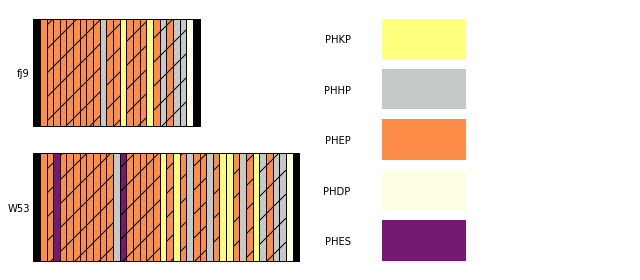

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# this was to double up ends to make double wide, doesn't work
#for strain in strains:
#    start = strains[strain][0]
#    end = strains[strain][-1]
#    strains[strain].insert(0, start)
#    strains[strain].insert(-1, end)

# colect all repeats and find unique ones to assign a color
uq_repeats = list(set([repeat[1] for repeat in strains for repeat in strains[repeat]]))

#np.random.seed(sum(map(ord, "palettes")))

col_dict = {}
col_opts = sns.xkcd_rgb.keys()
n = 0
for rep in uq_repeats:
    if rep == 'XXXXX':
        # set bad repeat to black, redundent
        col_dict[rep] = (0,0,0)
    else:
        col_dict[rep] = sns.xkcd_rgb[np.random.choice(col_opts, replace=False)] #palet[n]
    n+=1

## repeat plot
start_end = []
width = 1
spacer = 0

for i,strain in enumerate(strains.keys()):
    used_colors_dict = {}
    used_colors = []
    start = 0
    for dna, repeat in strains[strain]:
        if start == 0:
            # start of seq (not repeat)
            col_dict[repeat] = '#000000'
            col = '#000000'
            start_end.append(repeat)        

        elif repeat == strains[strain][-1][1]:
            # end of seq (not repeat)
            col_dict[repeat] = '#000000'
            col = '#000000'
            start_end.append(repeat)
        else:
            col=col_dict[repeat]
            spacer = 0
        start += width
        if col not in used_colors or col == '#ffffff':
            used_colors.append(col)
            used_colors_dict[col] = [(dna, repeat)]
            hatch=""
        else:
            # pep same, but DNA diff, make hatch
            found,notfound = 0,0
            for d, r in used_colors_dict[col]:
                try:
                    assert r == repeat
                except AssertionError:
                    print('start, end or error')
                    print(r)
                    print(repeat)
                if dna != d:
                    notfound+=1
                else:
                    found+=1
            used_colors_dict[col].append((dna, repeat))
            # ocnce it is found, dont hatch it again
            #if notfound != 0 and found ==0:
            # jan seems to hash even if it has been found before
            if notfound != 0:
                hatch="/"
            else:
                hatch = ""
        # could put logic here to make it white box
        axes[0].barh(i,width, left=start - width, color=col_dict[repeat],
                     hatch=hatch, align='center', edgecolor='black')
    print(used_colors_dict)

# get rid of xtics
axes[0].set_xticklabels('')
ind = np.arange(len(strains))
axes[0].set_yticks(ind)
labels1 = strains.keys()
axes[0].set_yticklabels(labels1)
# remove ticks and borders
axes[0].get_xaxis().set_ticks([])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].tick_params(axis=u'both', which=u'both',length=0)

# remove the non-repeat start and ends before making the key
assert len(start_end) % 2 == 0
for norep in start_end:
    col_dict.pop(norep, None)
    
# custom key on right plot
col2 = col_dict.values()
labels2 = col_dict.keys()
axes[1].barh(np.arange(len(labels2)),len(labels2)*[0.3], left=0.1, color=col2, align='center')
axes[1].set_xbound((0,1))
axes[1].set_xticklabels('')

# fix ticks
axes[1].set_yticks(np.arange(len(labels2)))
axes[1].set_yticklabels(labels2)
axes[1].get_xaxis().set_ticks([])
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

# turn of border and ticks
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].tick_params(axis=u'both', which=u'both',length=0)

#frameon=False

fig.tight_layout()
fig.savefig('test.png')
plt.show()

In [90]:
strains

{'W53': [('START', 'START'),
  ('CCACATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCCCACGAATCA', 'PHES'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCCCACGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCACGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCACGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATCATCCT', 'PHHP'),
  ('CCACATGAATCA', 'PHES'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCCCACGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATCATCCT', 'PHHP'),
  ('CCACATGAACCA', 'PHEP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATCATCCT', 'PHHP'),
  ('CCACATGAACCA', 'PHEP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCATGAACCA', 'PHEP'),
  ('CCTCATCATCCT', 'PHHP'),
  ('CCACATGAACCA', 'PHEP'),
  ('CCTCATAAACCA', 'PHKP'),
  ('CCTCACCATCCT', 'PHHP'),
  ('CCACATGAACCA', 

## Full run through for code

This code can be copied into a script, see notes

{'HUN127_CST20_alt_302bp.fa': [('START', 'START'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('END', 'END')], 'HUN95_CST20_alt_302bp.fa': [('START', 'START'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('END', 'END')], 'HMHc2_CST20_alt_303bp.fa': [('START', 'START'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('END', 'END')], 'HUN91_CST20_alt_305bp.fa': [('START', 'START'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('END', 'END')], 'HMHc5_CST20_alt_295bp.fa': [('START', 'START'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('END', 'END')], 'CH3_CST20_alt_305bp.fa': [('START', 'START'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('END', 'END')], 'HMHc9_CST20_alt_302bp.fa': [('START', 'START'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('GGACCT', 'GP'), ('END', 'END')], 'HUN93_CST20_alt_302bp.fa': [('START', 'START'), ('GGACCT', 'GP'), ('G

start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end or error
START
END
start, end

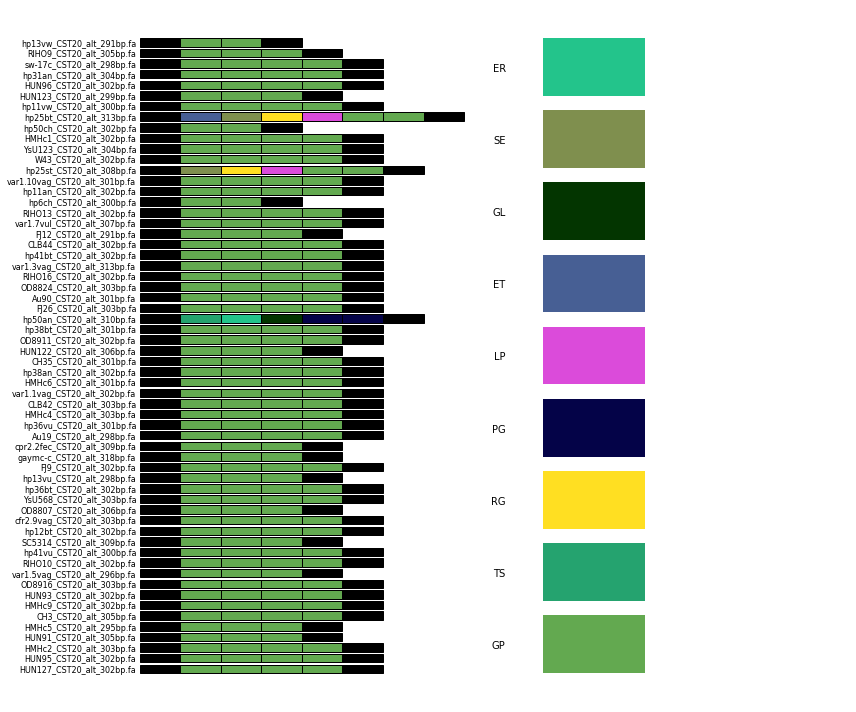

In [6]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import seaborn as sns

# SETTINGS
# NOTE 1.
# make this a sys.argv[1]
tar_fasta = './' # './testfile_2.fasta' 
AA_unit = 2 # 4
dna_unit = AA_unit * 3
AA_skipNterm = 8  # 12
dna_skipNterm = AA_skipNterm * 3
# If set AA_skipCterm to 0 if you want to capture all of the seq at the 3' end
AA_skipCterm = 0 # 12:-24 = 24 OR set to 0 to include all 3' seq
dna_skipCterm = AA_skipCterm * 3 # will be set to 0 if above is 0

strains = {}

with open(tar_fasta) as f:
    for rec in SeqIO.parse(f, 'fasta'):
        # DNA skip from AA skip
        data = []
        dna_start = rec[:dna_skipNterm]
        # logic to capture entire seq if requried
        if dna_skipCterm == 0:
            dna_string = rec[dna_skipNterm:] # captures 3' end
        else:
            dna_string = rec[dna_skipNterm:-dna_skipCterm]   
        data.append(('START', 'START'))
        start = 0
        end = dna_unit
        while end <= len(dna_string):
            dna_chunk = dna_string[start:end]
            # table 12 is yeast alt
            data.append((str(dna_chunk.seq), str(dna_chunk.translate(table=12).seq)))
            start = end
            end = end + dna_unit
        data.append(('END', 'END' ))
        strains[rec.id] = data
        
print(strains)
# NOTE 3. This needs to be saved as an outfile somehow

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10)) #9,4

# colect all repeats and find unique ones to assign a color
uq_repeats = list(set([repeat[1] for repeat in strains for repeat in strains[repeat]]))

#np.random.seed(sum(map(ord, "palettes")))

col_dict = {}
col_opts = sns.xkcd_rgb.keys()
n = 0
for rep in uq_repeats:
    if rep == 'XXXXX':
        # set bad repeat to black, redundent
        col_dict[rep] = (0,0,0)
    else:
        col_dict[rep] = sns.xkcd_rgb[np.random.choice(col_opts, replace=False)] #palet[n]
    n+=1

## repeat plot
start_end = []
width = 1
spacer = 0

for i,strain in enumerate(strains.keys()):
    used_colors_dict = {}
    used_colors = []
    start = 0
    for dna, repeat in strains[strain]:
        if start == 0:
            # start of seq (not repeat)
            col_dict[repeat] = '#000000'
            col = '#000000'
            start_end.append(repeat)        

        elif repeat == strains[strain][-1][1]:
            # end of seq (not repeat)
            col_dict[repeat] = '#000000'
            col = '#000000'
            start_end.append(repeat)
        else:
            col=col_dict[repeat]
            spacer = 0
        start += width
        if col not in used_colors or col == '#ffffff':
            used_colors.append(col)
            used_colors_dict[col] = [(dna, repeat)]
            hatch=""
        else:
            # pep same, but DNA diff, make hatch
            found,notfound = 0,0
            for d, r in used_colors_dict[col]:
                try:
                    assert r == repeat
                except AssertionError:
                    print('start, end or error')
                    print(r)
                    print(repeat)
                if dna != d:
                    notfound+=1
                else:
                    found+=1
            used_colors_dict[col].append((dna, repeat))
            # ocnce it is found, dont hatch it again
            #if notfound != 0 and found ==0:
            # jan seems to hash even if it has been found before
            if notfound != 0:
                hatch="/"
            else:
                hatch = ""
        # could put logic here to make it white box
        axes[0].barh(i,width, left=start - width, color=col_dict[repeat],
                     hatch=hatch, align='center', edgecolor='black')

# get rid of xtics
axes[0].set_xticklabels('')
ind = np.arange(len(strains))
axes[0].set_yticks(ind)
labels1 = strains.keys()
axes[0].set_yticklabels(labels1, fontsize=8) # SETS Font size

# remove ticks and borders
axes[0].get_xaxis().set_ticks([])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].tick_params(axis=u'both', which=u'both',length=0)

# remove the non-repeat start and ends before making the key
assert len(start_end) % 2 == 0
for norep in start_end:
    col_dict.pop(norep, None)
    
# custom key on right plot
col2 = col_dict.values()
labels2 = col_dict.keys()
axes[1].barh(np.arange(len(labels2)),len(labels2)*[0.3], left=0.1, color=col2, align='center')
axes[1].set_xbound((0,1))
axes[1].set_xticklabels('')

# fix ticks
axes[1].set_yticks(np.arange(len(labels2)))
axes[1].set_yticklabels(labels2)
axes[1].get_xaxis().set_ticks([])
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

# turn of border and ticks
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].tick_params(axis=u'both', which=u'both',length=0)

# # NOTE 2. set outfile as sys.argv
fig.tight_layout()
fig.savefig('CST20R1_24_0.pdf')
plt.show()

In [7]:
!which python

/home/dpidave/miniconda3/bin/python


In [9]:
import Bio
print(Bio.__version__)

1.71
